In [2]:
"Jupyter Lab Extension"
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.nn.functional as F
from torch.nn.modules.utils import _pair
import torch.utils as utils
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision import models

import tensorwatch as tw

import matplotlib.pyplot as plt

import os
os.chdir("/projects/2019연구학점제/")
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import time
import copy

device = torch.device('cuda')

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                          shuffle=True, num_workers=10)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=10)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


FigureCanvasNbAgg()

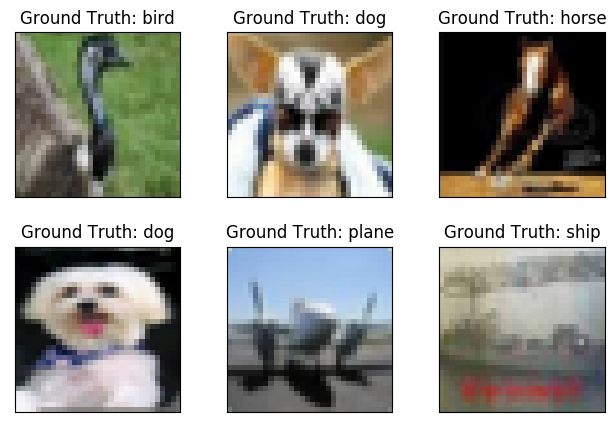

In [3]:
examples = enumerate(trainloader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow((example_data[i].transpose(0,1).transpose(1,2) + 1)/2)
    plt.title("Ground Truth: {}".format(classes[example_targets[i]]))
    plt.xticks([])
    plt.yticks([])
fig

In [4]:
# streams will be stored in test.log file
w = tw.Watcher(filename='test.log')

# create a stream for logging
s = w.create_stream(name='metric1')

# generate Jupyter Notebook to view real-time streams
w.make_notebook()

for i in range(1000):
    # write x,y pair we want to log
    s.write((i, i*i)) 

    time.sleep(1)

<h1>Fine Tuning</h1>

In [5]:
model = models.densenet161(pretrained=True).cuda()
model.classifier = nn.Linear(2208, 10, bias=True).cuda()
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD([
                {'params': model.features.parameters()},
                {'params': model.classifier.parameters(), 'lr': 1e-2}
            ], lr=1e-3, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=100):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs ))
        print('-' * 10)
        
        model.train()
                
        scheduler.step()
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
            loss.backward()
            optimizer.step()
        
        running_loss = 0.0
        running_corrects = 0
        
        model.eval()
        for i, data in enumerate(testloader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
        
            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(testloader)
        epoch_acc = running_corrects.double() / len(testloader)

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
train_model(model, criterion, optimizer, scheduler, 1000)

Epoch 1/1000
----------
Loss: 63.2999 Acc: 78.3100
Epoch 2/1000
----------
Loss: 52.1475 Acc: 82.2600
Epoch 3/1000
----------
Loss: 53.6551 Acc: 82.6500
Epoch 4/1000
----------
Loss: 59.9677 Acc: 83.1200
Epoch 5/1000
----------
Loss: 65.1655 Acc: 83.4300
Epoch 6/1000
----------
Loss: 68.6092 Acc: 83.5900
Epoch 7/1000
----------
Loss: 72.1603 Acc: 83.5800
Epoch 8/1000
----------
Loss: 77.2116 Acc: 83.8800
Epoch 9/1000
----------
Loss: 79.4687 Acc: 84.3200
Epoch 10/1000
----------
Loss: 81.5804 Acc: 84.5500
Epoch 11/1000
----------
Loss: 80.7905 Acc: 84.4400
Epoch 12/1000
----------
Loss: 82.0025 Acc: 84.8700
Epoch 13/1000
----------
Loss: 82.0407 Acc: 84.6100
Epoch 14/1000
----------
Loss: 85.3785 Acc: 84.6100
Epoch 15/1000
----------
Loss: 85.5092 Acc: 84.9700
Epoch 16/1000
----------
Loss: 503.3620 Acc: 52.0200
Epoch 17/1000
----------
Loss: 62.3212 Acc: 83.3200
Epoch 18/1000
----------
Loss: 75.9564 Acc: 83.5300
Epoch 19/1000
----------
Loss: 72.6099 Acc: 84.8300
Epoch 20/1000
------

KeyboardInterrupt: 